In [1]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)

from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, LSTM, LayerNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import textalloc as ta
import optuna
import pickle
import xgboost as xgb
import math

/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
class GameProbability():
    def __init__(self, path, normalizer_path='./saved_models/normalizer.pkl'):
        self.data = pd.read_csv(path).dropna(how='any', axis=0)
        self.normalizer_path = normalizer_path
        self.set_normalizer()


    def pad_arrays(self, array, max_length):
        """
        Pads each array in the given list of arrays to the specified maximum length.

        If the length of an array is greater than the maximum length, it truncates the array to the maximum length.
        If the length of an array is less than the maximum length, it pads the array with zeros at the beginning.

        Args:
            array (list): A list of arrays.
            max_length (int): The maximum desired length.

        Returns:
            list: The padded arrays.
        """
        padded_arrays = []
        for arr in array:
            if len(arr) > max_length: ##TODO allow for longer games
                arr = arr[-max_length:,:]
            pad_width = ((max_length - len(arr), 0), (0, 0))  # Pad at the beginning with zeros
            padded_array = np.pad(arr, pad_width, mode='constant', constant_values=-1)
            padded_arrays.append(padded_array)
        return padded_arrays
    
    
    def process_data(self, features):
        def add_team_swap(data):
            """
            Applies a team swap operation to the game data DataFrame. This is a form of data augmentation that
            relies on the incorrect assumption that being the home team and away team doesn't matter. However,
            in training we believe the additional data is more impactful than the advantage of being the home team.

            Swaps the home team's score with the away team's score, flips the home team win indicator,
            toggles the `is_home_team` flag, and modifies the game ID to indicate the team swap.

            Args:
                data (pandas.DataFrame): A DataFrame containing game data.

            Returns:
                pandas.DataFrame: The modified DataFrame with the team swap applied.
            """
            all_games = []
            for game in data.gameID.unique():
                GAME = data[data.gameID == game]
                GAME['temp'] = GAME['home_team_score']
                GAME['home_team_score'] = GAME['away_team_score']
                GAME['away_team_score'] = GAME['temp']
                GAME['home_team_win'] = (~GAME.home_team_win.astype(bool)).astype(int)
                GAME['is_home_team'] = ~GAME['is_home_team']
                GAME['gameID'] = GAME['gameID'] + '-teamswap'
                all_games.append(GAME.drop('temp', axis=1))
            return pd.concat([pd.concat(all_games), data])

        def add_x_swap(data):
            """
            Applies a thrower swap operation to the game data DataFrame. This is a form of data augmentation
            that assumes the game probability should be the same no matter which side of the field the disc is on.

            Multiplies the `thrower_x` column by -1 and modifies the game ID to indicate the thrower swap.

            Args:
                data (pandas.DataFrame): A DataFrame containing game data.

            Returns:
                pandas.DataFrame: The modified DataFrame with the thrower swap applied.
            """
            FLIPPED_X = data.copy()
            FLIPPED_X.thrower_x = FLIPPED_X.thrower_x * -1
            FLIPPED_X['gameID'] = FLIPPED_X['gameID'] + '-throwswap'
            return pd.concat([data, FLIPPED_X])

        def preprocess_data(data, features, label, testIDs):
            """
            Preprocess the data by grouping, sorting, and converting it to numpy arrays.

            Parameters:
                data (DataFrame): Input data.
                features (list): List of feature column names.
                label (str): Label column name.
                testIDs (list): List of gameIDs for test data.

            Returns:
                group_train_arrays (list): List of numpy arrays for training data groups.
                group_test_arrays (list): List of numpy arrays for test data groups.
                max_length (int): Maximum length among all groups.
            """
            # Step 1: Group the data by 'gameID'
            grouped = data.groupby(['gameID'])

            # Step 2: Sort the groups by length
            sorted_groups = sorted(grouped[features + label], key=lambda x: len(x[1]), reverse=True)

            # Step 3: Convert each group to a numpy array
            group_train_arrays = []
            group_test_arrays = []
            max_length = 0

            for gameID, group in sorted_groups:
                group_array = group.values  # Convert group DataFrame to a numpy array
                if len(group_array) > max_length:
                    max_length = len(group_array)
                if gameID in testIDs:
                    group_test_arrays.append(group_array)
                else:
                    group_train_arrays.append(group_array)

            return group_train_arrays, group_test_arrays, max_length

        def format_data(padded_train_arrays, padded_test_arrays):
            """
            Process the data by converting it into numpy arrays, normalizing the features,
            and converting them to tensors.

            Parameters:
                padded_train_arrays (list): List of padded train arrays.
                padded_test_arrays (list): List of padded test arrays.

            Returns:
                X_train (ndarray): Numpy array for training features.
                X_test (ndarray): Numpy array for test features.
                y_train (ndarray): Numpy array for training labels.
                y_test (ndarray): Numpy array for test labels.
                X_train_normalized (ndarray): Numpy array for normalized training features.
                X_test_normalized (ndarray): Numpy array for normalized test features.
            """
            def normalize_data(X_train, X_test):
                """
                Normalize the training and test data using Min-Max scaling.

                Parameters:
                    X_train (ndarray): Training data array.
                    X_test (ndarray): Test data array.

                Returns:
                    X_train_normalized (ndarray): Normalized training data.
                    X_test_normalized (ndarray): Normalized test data.
                """

                # Create a normalizer object
                self.normalizer = MinMaxScaler()

                # Normalize the training data
                X_train_flattened = X_train.reshape(-1, X_train.shape[-1])
                mask = (X_train_flattened[:, 0] != -1)
                X_train_normalized = X_train_flattened.copy()
                X_train_normalized[mask] = self.normalizer.fit_transform(X_train_flattened[mask])
                X_train_normalized = X_train_normalized.reshape(X_train.shape)

                # Normalize the test data using the same normalization parameters
                X_test_flattened = X_test.reshape(-1, X_test.shape[-1])
                mask = (X_test_flattened[:, 0] != -1)
                X_test_normalized = X_test_flattened.copy()
                X_test_normalized[mask] = self.normalizer.transform(X_test_flattened[mask])
                X_test_normalized = X_test_normalized.reshape(X_test.shape)
                
                with open(self.normalizer_path, 'wb') as file:
                    pickle.dump(self.normalizer, file)

                return X_train_normalized, X_test_normalized
            
            # Convert the list of arrays into a 3D numpy array
            data_train_array = np.stack(padded_train_arrays)
            data_test_array = np.stack(padded_test_arrays)

            # Split the arrays into features and labels
            X_train, X_test, y_train, y_test = data_train_array[:,:,:-1], data_test_array[:,:,:-1], data_train_array[:,:,-1], data_test_array[:,:,-1]

            # Normalize the features
            X_train_normalized, X_test_normalized = normalize_data(X_train, X_test)

            # Convert to tensors
            X_train, X_test, y_train, y_test, X_train_normalized, X_test_normalized = (
                X_train.astype(np.float32),
                X_test.astype(np.float32),
                y_train.astype(np.float32),
                y_test.astype(np.float32),
                X_train_normalized.astype(np.float32),
                X_test_normalized.astype(np.float32)
            )

            return y_train, y_test, X_train_normalized, X_test_normalized
        
        label = ['home_team_win']
        # Augment data and split into training and testing
        _, testIDs = train_test_split(self.data.gameID.unique(), test_size=0.2, random_state=42)
        data = add_x_swap(add_team_swap(self.data))

        group_train_arrays, group_test_arrays, max_length = preprocess_data(data, features, label, testIDs)

        # Pad the variable-length groups
        padded_train_arrays, padded_test_arrays = self.pad_arrays(group_train_arrays, max_length), self.pad_arrays(group_test_arrays, max_length)

        # Normalize and convert the padded arrays
        y_train, y_test, X_train_normalized, X_test_normalized = format_data(padded_train_arrays, padded_test_arrays)

        return X_train_normalized, X_test_normalized, y_train, y_test
    

    def set_normalizer(self):
        with open(self.normalizer_path, 'rb') as file:
            self.normalizer = pickle.load(file)
            

    def create_model(self, lstm_units, input_shape):
        model = tf.keras.Sequential()
        model.add(BatchNormalization(input_shape=input_shape))
        model.add(LSTM(units=lstm_units, return_sequences=True))
        model.add(LayerNormalization())
        model.add(Dense(units=1, activation='sigmoid'))
        return model
    
    
    def masked_loss(self, mask_value):
        def loss_function(y_true, y_pred):
            mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
            loss = K.binary_crossentropy(y_true * mask, y_pred * mask)
            return loss
        return loss_function

    
    def process_new_game(self, DATA, features, max_length=629):
        def normalize_new_game(X, normalizer):
                # Flatten the 3D training data
                X_flattened = X.reshape(-1, X.shape[-1])

                # Create a mask for padded values
                mask = (X_flattened[:, 0] != -1)

                # Apply normalization only to non-padded values
                X_normalized = X_flattened.copy()
                X_normalized[mask] = normalizer.transform(X_flattened[mask])

                # Reshape the normalized data back to the original shape
                X_normalized = X_normalized.reshape(X.shape)
                return X_normalized

        groups = DATA.groupby(['gameID'])

        group_arrays = []
        teams = []
        for gameID, group in groups:
            group_array = group[features+['home_team_win']].values  # Convert group DataFrame to a numpy array
            if len(group_array) > max_length:
                print(f'skipping game: {gameID} len: {len(group_array)}')
                continue
            teams.append((group.home_teamID.iloc[0], group.away_teamID.iloc[0], gameID[:10]))
            group_arrays.append(group_array)
        padded_arrays = self.pad_arrays(group_arrays, 629) #TODO allow for more throws
        data_array = np.stack(padded_arrays)
        X = data_array[:,:,:-1]
        X = normalize_new_game(X, self.normalizer)
        return X, teams


    def load_model(self, model_path='./saved_models/accuracy_loss_model.h5'):
        self.model = keras.models.load_model(model_path, custom_objects={'loss_function':self.masked_loss})

    def plot_games(self, DATA, features, show=False):
        X, teams = self.process_new_game(DATA, features)
        def get_arrays(df, predictions):
            txts, xs, ys = [], [], []
            for _, group_df in df[(df.times>0) & (df.total_points < 100)].groupby('total_points'):
                row = group_df.iloc[0]
                txt = f'{int(row.home_team_score)}-{int(row.away_team_score)}'
                x = 48 - row.times/60
                y = predictions.flatten()[min(group_df.index)]
                txts.append(txt)
                xs.append(x)
                ys.append(y)
            return txts, xs, ys
        width = 2
        height = math.ceil(X.shape[0] / 2)
        fig, ax = plt.subplots(height, width, figsize=(width*5,height*5))
        ax = ax.flatten()
        num_plots = X.shape[0]
        for idx in range(num_plots):
            current_game = X[idx,:,:].astype(np.float32)
            df = pd.DataFrame(self.normalizer.inverse_transform(current_game), columns=features)
            predictions = self.model.predict(current_game.reshape(1, 629, -1))
            txts, xs, ys = get_arrays(df, predictions)
            ax[idx].scatter(xs, ys, c='r', s=0.1)
            ta.allocate_text(fig, ax[idx], xs, ys, txts, x_scatter=xs, y_scatter=ys, textsize=7, linecolor='black')
            
            ax[idx].plot(48 - df[(df.times>0) & (df.total_points < 100)].times/60, predictions[np.array([(df.times>0) & (df.total_points < 100)])].flatten(), c='r')
            ax[idx].grid(alpha=0.3)
            ax[idx].set_yticks(np.arange(0,1.1,0.1))
            ax[idx].set_ylim([0,1])
            ax[idx].title.set_text(f'{teams[idx][1]} at {teams[idx][0]} on {teams[idx][2]}')
        if show:
            plt.show()
        return fig, ax

In [3]:
features = ['thrower_x', 'thrower_y', 'possession_num', 'possession_throw',
       'game_quarter', 'quarter_point', 'is_home_team', 'home_team_score',
       'away_team_score','total_points', 'times', 'score_diff']
game_prob = GameProbability('../data/processed/throwing_0627.csv')
game_prob.load_model()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-07-06 17:59:11.694442: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-06 17:59:11.694760: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


skipping game: 2022-05-13-SEA-SLC len: 631


2023-07-06 17:59:30.809330: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-06 17:59:30.973374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-06 17:59:31.072037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


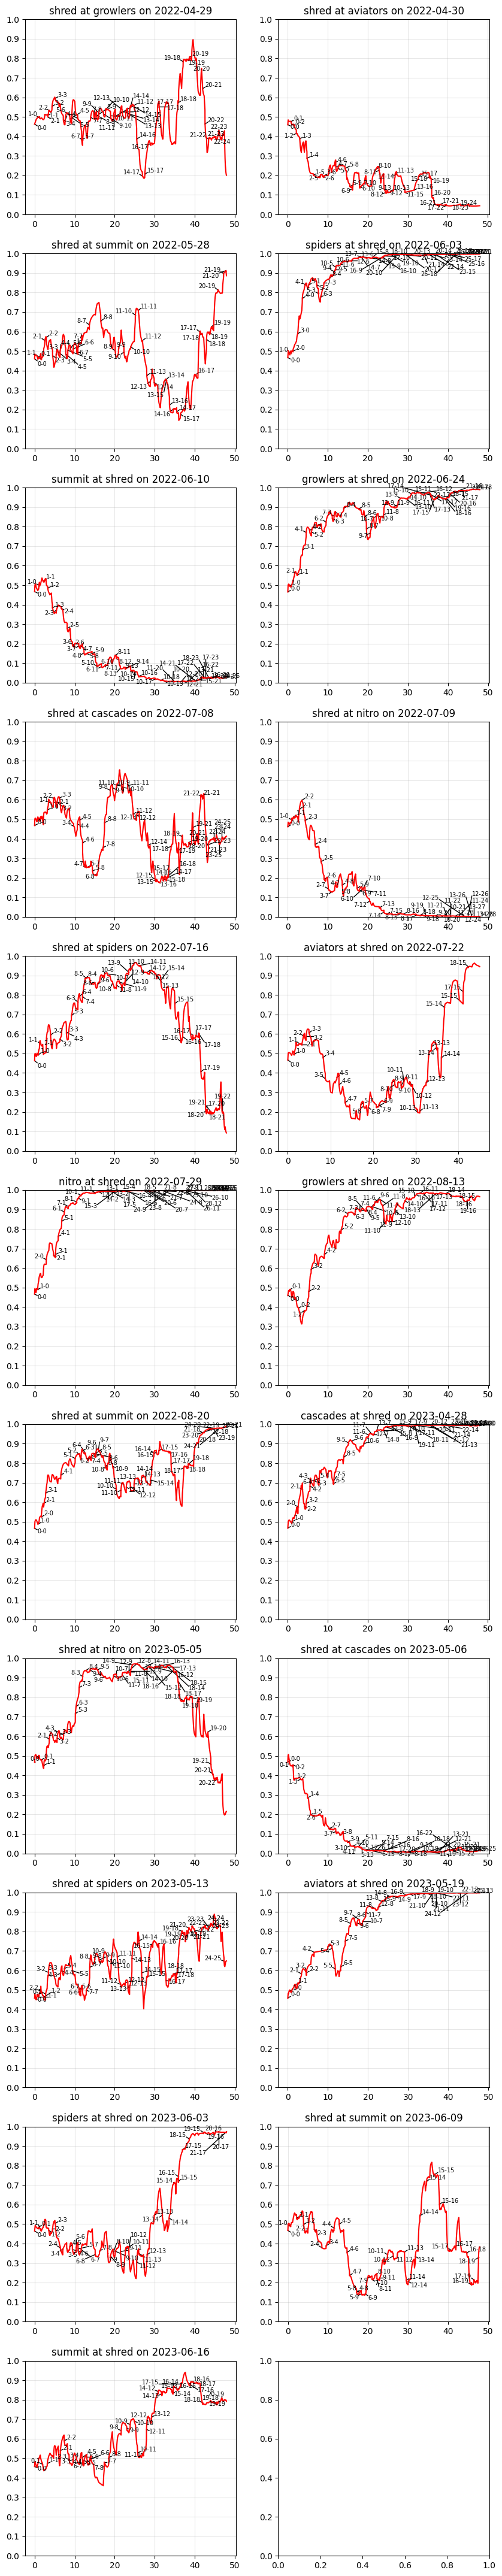

In [5]:
WEEKEND_GAMES = pd.read_csv('../data/processed/games_0630.csv')
ALL_GAMES = pd.read_csv('../data/processed/all_games_0703.csv')
gameIDs = [x for x in ALL_GAMES.gameID.unique() if 'SLC' in x]
fig, axs = game_prob.plot_games(ALL_GAMES[ALL_GAMES.gameID.isin(gameIDs)], features)
plt.show()

In [4]:
def accuracy_objective(trial, X_train, X_test, y_train, y_test, eval=False):
    # Define the hyperparameters to tune
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    num_epochs = 100
    batch_size = trial.suggest_categorical('batch_size',[16,32,64])

    # Create the model instance
    model = game_prob.create_model(lstm_units, (X_train.shape[1], X_train.shape[2]))

    # Define the optimizer and learning rate scheduler
    optimizer = Adam(learning_rate=learning_rate)
    scheduler = LearningRateScheduler(lambda epoch: learning_rate * 0.1 ** (epoch // 10))
    # Define early stopping callback
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer=optimizer, loss=game_prob.masked_loss(-1), metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_test, y_test), callbacks=[scheduler, early_stopping])

    loss, accuracy = model.evaluate(X_test, y_test)

    if eval:
        return model

    # Return the evaluation metric (e.g., accuracy)
    return accuracy

In [19]:
storage='sqlite:///test_db.db'
study_name='lstm_v1_accuracy'
features = ['thrower_x', 'thrower_y', 'possession_num', 'possession_throw',
       'game_quarter', 'quarter_point', 'is_home_team', 'home_team_score',
       'away_team_score','total_points', 'times', 'score_diff']
study = optuna.load_study(study_name, storage)
X_train, X_test, y_train, y_test, normalizer = game_prob.process_data(features)
accuracy_model = accuracy_objective(study.best_trial, X_train, X_test, y_train, y_test, True)
accuracy_model.evaluate(X_test, y_test)
accuracy_model.save('./saved_models/accuracy_loss_model.h5')

/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_88294/2943733603.py:6: FutureWarning: load_study(): Please give all values as keyword arguments. See https://github.com/optuna/optuna/issues/3324 for details.
  study = optuna.load_study(study_name, storage)
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_88294/4290610367.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GAME['temp'] = GAME['home_team_score']
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_88294/4290610367.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Epoch 1/100


2023-07-01 11:51:12.191622: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-01 11:51:12.762172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 11:51:13.071860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 11:51:14.737350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - ETA: 0s - loss: 0.5368 - accuracy: 0.3914

2023-07-01 11:51:38.042100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 11:51:38.177880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 29s 268ms/step - loss: 0.5368 - accuracy: 0.3914 - val_loss: 0.4545 - val_accuracy: 0.4803 - lr: 0.0051
Epoch 2/100
84/84 [==============================] - 15s 175ms/step - loss: 0.4453 - accuracy: 0.4777 - val_loss: 0.4951 - val_accuracy: 0.4392 - lr: 0.0051
Epoch 3/100
84/84 [==============================] - 13s 156ms/step - loss: 0.3754 - accuracy: 0.5380 - val_loss: 0.3377 - val_accuracy: 0.6049 - lr: 0.0051
Epoch 4/100
84/84 [==============================] - 12s 148ms/step - loss: 0.3695 - accuracy: 0.5453 - val_loss: 0.3091 - val_accuracy: 0.5915 - lr: 0.0051
Epoch 5/100
84/84 [==============================] - 13s 151ms/step - loss: 0.3360 - accuracy: 0.5671 - val_loss: 0.3055 - val_accuracy: 0.5815 - lr: 0.0051
Epoch 6/100
84/84 [==============================] - 15s 173ms/step - loss: 0.3370 - accuracy: 0.5620 - val_loss: 0.3756 - val_accuracy: 0.5487 - lr: 0.0051
Epoch 7/100
84/84 [==============================] - 14s 171ms/step - 

[0.2981985807418823, 0.5931615829467773]

In [4]:
DATA = pd.read_csv('../data/processed/all_games_0703.csv')
game_prob.set_normalizer()
gameID = '2023-05-13-PHI-BOS'
max_length = 629
model = game_prob.model
normalizer = game_prob.normalizer


In [8]:
def plot_game(self, gameID, max_length = 629):
    test_game = self.data[self.data.gameID == gameID][features]
    test_game = self.normalizer.transform(test_game)
    pad_width = ((max_length - len(test_game), 0), (0, 0))  # Pad at the beginning with zeros
    test_game = np.pad(test_game, pad_width, mode='constant', constant_values=-1).astype(np.float32)
    out = self.model.predict(test_game.reshape(1, 629, -1))
    df = pd.DataFrame(self.normalizer.inverse_transform(test_game), columns=features)
    preds = out[np.array([df.times > 0])].flatten()
    annotations = []
    counter = 0
    txts, xs, ys = [], [], []
    for _, group_df in df[df.times>0].groupby('total_points'):
        counter = counter + 1
        row = group_df.iloc[0]
        txt = f'{int(row.home_team_score)}-{int(row.away_team_score)}'
        x = 48 - row.times/60
        y = out.flatten()[min(group_df.index)]
        txts.append(txt)
        xs.append(x)
        ys.append(y)
    fig, ax = plt.subplots()
    ax.scatter(xs, ys, c='r', s=0.1)
    ta.allocate_text(fig,ax,xs,ys,
                    txts,
                    x_scatter=xs, y_scatter=ys,
                    textsize=10, linecolor='black')


    ax.plot(48 - df[df.times > 0].times/60, preds, c='r')
    plt.grid(alpha=0.3)
    plt.title(gameID)
    plt.ylim([0,1])
    plt.show()

In [9]:
from audl.stats.endpoints.playerstats import PlayerStats
import pandas as pd
year = 2021
dfs = []
while True:
    df = PlayerStats(year, 'total', 'all').fetch_table()
    df['year'] = year
    dfs.append(df)
    year = year+1
    if len(df) == 0:
        break
player_stats_by_year = pd.concat(dfs)

In [14]:
player_stats_by_year.teams.unique()

array(['NY', 'RAL', 'PIT', 'CHI', 'LA', 'MTL', 'BOS', 'ATL', 'PHI', 'DC',
       'DET', 'MIN', 'AUS', 'SD', 'MAD', 'DAL', 'TOR', 'SJ', 'IND', 'TB',
       'OTT', 'SEA', 'BOS, PIT', 'SLC', 'POR', 'COL', 'ATX', 'CAR', 'OAK',
       'ATL, MAD', 'POR, SEA', 'DAL, PIT', 'HTX'], dtype=object)

/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



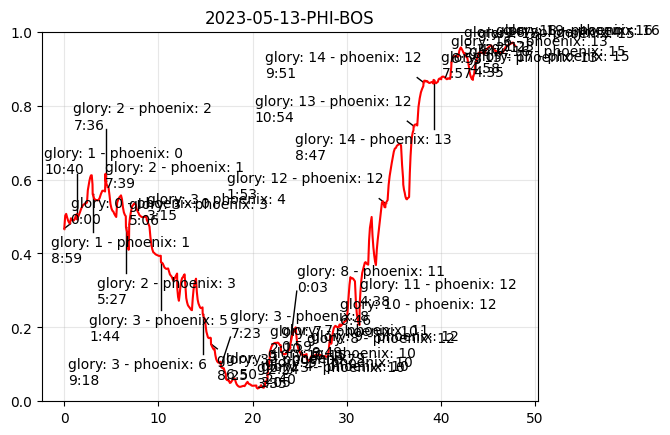

In [128]:

test_game = DATA[DATA.gameID == gameID]
home_team = test_game.home_teamID.iloc[0]
away_team = test_game.away_teamID.iloc[0]
test_game = test_game[features]
test_game = normalizer.transform(test_game)
pad_width = ((max_length - len(test_game), 0), (0, 0))  # Pad at the beginning with zeros
test_game = np.pad(test_game, pad_width, mode='constant', constant_values=-1).astype(np.float32)
out = model.predict(test_game.reshape(1, 629, -1))
df = pd.DataFrame(normalizer.inverse_transform(test_game), columns=features)
preds = out[np.array([df.times > 0])].flatten()
annotations = []
counter = 0
txts, xs, ys = [], [], []
for _, group_df in df[df.times>0].groupby('total_points'):
    counter = counter + 1
    row = group_df.iloc[0]
    
    x = 48 - row.times/60
    y = out.flatten()[min(group_df.index)]
    minutes = (48 - x) % 12 // 1
    seconds = round((48 - x) % 12 % 1 * 60)
    txt = f'{home_team}: {int(row.home_team_score)} - {away_team}: {int(row.away_team_score)}\n{int(minutes)}:{seconds:02d}'
    txts.append(txt)
    xs.append(x)
    ys.append(y)
fig, ax = plt.subplots()
ax.scatter(xs, ys, c='r', s=0.1)
ta.allocate_text(fig,ax,xs,ys,
                txts,
                x_scatter=xs, y_scatter=ys,
                textsize=10, linecolor='black')


ax.plot(48 - df[df.times > 0].times/60, preds, c='r')
ax.grid(alpha=0.3)
ax.set_title(gameID)
ax.set_ylim([0,1])
plt.show()

In [16]:
import plotly.express as px

In [42]:
hover_text = pd.DataFrame()
hover_text['xs'] = xs
hover_text['ys'] = ys
hover_text['txts'] = txts

In [62]:
import plotly.graph_objects as go

In [84]:
DATA.home_teamID.unique()

array(['union', 'shred', 'spiders', 'sol', 'cascades', 'mechanix',
       'windchill', 'aviators', 'royal', 'breeze', 'rush', 'phoenix',
       'hustle', 'alleycats', 'legion', 'havoc', 'flyers', 'nitro',
       'thunderbirds', 'empire', 'glory', 'summit', 'outlaws', 'growlers',
       'radicals', 'cannons'], dtype=object)

In [81]:
matching_elements = [element for element in DATA.gameID.unique() if any(substring in element for substring in ['2021', '2022'])]


In [85]:
teams = ['union', 'shred', 'spiders', 'sol', 'cascades', 'mechanix',
       'windchill', 'aviators', 'royal', 'breeze', 'rush', 'phoenix',
       'hustle', 'alleycats', 'legion', 'havoc', 'flyers', 'nitro',
       'thunderbirds', 'empire', 'glory', 'summit', 'outlaws', 'growlers',
       'radicals', 'cannons']

array([10.        , 11.33333333, 13.01666667, 14.35      , 14.4       ,
       16.55      , 16.9       , 18.75      , 20.26666667, 24.69999797,
       25.58333333, 26.61666667, 27.16666667, 30.41666667, 30.91666667,
       31.3333313 , 31.6       , 31.83333333, 33.01666667, 33.95      ,
       35.75      , 36.18333333, 39.23333333, 41.36666667, 44.11666768,
       47.1       , 48.15      , 49.21666667, 50.04999949, 51.11666616,
       52.46666667, 53.03333333, 53.41666667, 53.96666692, 55.81666667,
       56.61666667])

In [129]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=48 - df[df.times > 0].times/60,
    y=preds,
    hoverinfo="skip",
    marker=dict(
        color="blue"
    ),
    showlegend=False
))
fig.add_trace(go.Scatter(
    mode='markers',
    x=xs,
    y=ys,
    hovertext=txts,
    hoverinfo="text",
    marker=dict(
        color="black",
        size=5
    ),
    showlegend=False,
    customdata=txts
))
fig.update_layout(title=f'{home_team} at {away_team} on {gameID[:10]}', title_x=0.5, xaxis_title="Time Passed", yaxis_title="Win Probability",
                    yaxis_range=[0,1], xaxis_range=[0,48],
                    xaxis = dict(
                    tick0=0, dtick = 12, tickvals=[0, 12, 24, 36], ticktext=['1', '2', '3', '4']),
                    yaxis=dict(tick0=0, dtick=0.1))
fig.show()